# Weekend vs Weekday Behavior
Hypothesis:
On weekends, participants sleep longer but are less active.   

Data Needed:
Combine ActivityDate and date fields → determine day of week    


Compare mean sleep hours and mean active minutes between weekdays vs weekends.

## Hypothesis

For this project I focused on one main question:

> **Hypothesis:** On weekends, people sleep longer but are less active than on weekdays.

“Weekdays” are Monday–Friday.
“Weekends” are Saturday and Sunday.

---

## Data Sources and Main Variables

The notebook uses Fitbit data from two time periods. It loads two kinds of files:

1. **Daily Activity data** (`dailyActivity_merged.csv`)
2. **Minute-by-minute Sleep data** (`minuteSleep_merged.csv`)

From these raw files, the notebook builds the variables needed to test the hypothesis.

### Key Variables

After processing, the important variables are:

* **Id**
  A code for each person wearing a Fitbit (no names, just numbers).

* **Date**
  The calendar day (for example, 2016-03-25).

* **TotalMinutesAsleep**
  How many minutes a person was asleep that day.
  This is calculated by adding up all the sleep minutes from the minute-by-minute file.

* **SleepHours**
  TotalMinutesAsleep divided by 60, so we can talk about “hours of sleep” instead of minutes.

* **VeryActiveMinutes**
  The number of minutes per day when the person was in “very active” motion according to the Fitbit (for example, intense walking or exercise).

* **TotalSteps**
  The total number of steps taken that day.

* **DayOfWeek**
  The name of the day: Monday, Tuesday, …, Sunday. This is computed from the Date.

* **IsWeekend**
  A true/false flag:

  * `True` if the day is Saturday or Sunday
  * `False` if the day is Monday–Friday

This last variable (IsWeekend) is crucial, because it lets us split the data into **weekdays** and **weekends** for comparison.

---

## How the Variables Were Extracted and Built

### 1. Loading the raw files

The notebook defines a helper function `load_fitbit(file_name)` that:

1. Loops over each time period folder.
2. Builds the full file path to the CSV file inside that period.
3. Reads the CSV into a pandas DataFrame (a table in Python).
4. Adds a column called **Period** so we know which time window the data came from.
5. Stacks the DataFrames for all periods into one big table.

This function is used to load:

* `activity_df = load_fitbit("dailyActivity_merged.csv")`
* `sleep_minutes_df = load_fitbit("minuteSleep_merged.csv")`

So now we have:

* A **daily activity** table.
* A **minute-by-minute sleep** table.

### 2. Turning minute-by-minute sleep into daily sleep

The minute sleep file has one row for each minute that the person is asleep. To turn this into total sleep per *day*, the notebook does:

1. Converts the `date` column to a real date-time data type:

   ```python
   sleep_minutes_df["date"] = pd.to_datetime(sleep_minutes_df["date"], errors="coerce")
   ```
2. Creates a new column called `DateOnly` that keeps just the calendar date (year-month-day), not the time:

   ```python
   sleep_minutes_df["DateOnly"] = sleep_minutes_df["date"].dt.date
   ```
3. Groups by **Id** and **DateOnly**, and sums the sleep minutes:

   ```python
   daily_sleep = (
       sleep_minutes_df
       .groupby(["Id", "DateOnly"], as_index=False)
       .agg({"value": "sum"})
       .rename(columns={"DateOnly": "Date", "value": "TotalMinutesAsleep"})
   )
   ```
4. Adds **SleepHours**:

   ```python
   daily_sleep["SleepHours"] = daily_sleep["TotalMinutesAsleep"] / 60
   ```

At this point, `daily_sleep` has **one row per person per day**, with how many minutes and hours they slept that day.

### 3. Preparing the daily activity data

The notebook also prepares a daily activity table with:

* **Id**
* **Date**
* **VeryActiveMinutes**
* **TotalSteps**

We can see from the printed table that the daily activity table has shape `(1397, 4)` and includes exactly these four columns. Dates are aligned so they match the sleep dates.

### 4. Merging sleep and activity

To analyze sleep and activity together, we need them in the same table. The notebook:

* Merges `daily_sleep` and the daily activity table on **Id** and **Date**.

The merged table has:

* Id
* Date
* VeryActiveMinutes
* TotalSteps
* TotalMinutesAsleep
* SleepHours

So now we know for each (person, day) **how long they slept** and **how active they were**.

### 5. Adding DayOfWeek and IsWeekend

From the Date, the notebook adds:

1. **DayOfWeek**:
   Uses the date to compute the weekday name (“Monday”, “Tuesday”, …).
2. **IsWeekend**:
   Sets:

   * `True` if DayOfWeek is Saturday or Sunday
   * `False` otherwise

The sample table in the notebook looks like this (simplified):

| Id      | Date       | VeryActiveMinutes | TotalSteps | SleepHours | DayOfWeek | IsWeekend |
| ------- | ---------- | ----------------- | ---------- | ---------- | --------- | --------- |
| 150396… | 2016-03-25 | 33                | 11004      | 7.07       | Friday    | False     |
| 150396… | 2016-03-26 | 89                | 17609      | 8.52       | Saturday  | True      |
| 150396… | 2016-03-27 | 56                | 12736      | 8.88       | Sunday    | True      |

This is exactly what we need to compare weekdays vs weekends.

---

## How the Analysis Was Done

Once the variables are ready, the notebook compares weekdays and weekends in two main ways: **descriptive statistics** and **statistical tests**.

### 1. Comparing averages for weekdays vs weekends

First, it groups the data by **IsWeekend** and calculates summary statistics for both **SleepHours** and **VeryActiveMinutes**:

| IsWeekend | SleepHours mean | SleepHours std | SleepHours count | VeryActiveMinutes mean | VeryActiveMinutes std | VeryActiveMinutes count |
| --------- | --------------- | -------------- | ---------------- | ---------------------- | --------------------- | ----------------------- |
| False     | 7.72            | 2.80           | 461              | 23.11                  | 29.82                 | 461                     |
| True      | 8.62            | 3.68           | 185              | 22.30                  | 42.10                 | 185                     |

**What this table tells us:**

* **SleepHours**

  * **Weekdays (False):** about **7.7 hours** of sleep on average.
  * **Weekends (True):** about **8.6 hours** of sleep on average.
  * So, people sleep roughly **0.9 hours (about 54 minutes) more** on weekends.

* **VeryActiveMinutes**

  * **Weekdays:** about **23.1 minutes** of very active time per day.
  * **Weekends:** about **22.3 minutes** of very active time per day.
  * So, activity is slightly lower on weekends, but the difference is very small.

This already gives a basic picture: more sleep on weekends, almost the same activity.

### 2. Statistical tests (t-tests)

To see if these differences are **likely real** and not just random noise, the notebook runs **t-tests** for:

* SleepHours on weekdays vs weekends
* VeryActiveMinutes on weekdays vs weekends

A **t-test** is a basic statistical test that:

* Compares the means (averages) of two groups.
* Gives a **p-value**, which tells us how likely we would see a difference this big **just by random chance** if there was actually no real difference.

In the notebook, the results are printed as:

* **SleepHours → t = 3.00, p = 0.0030**
* **VeryActiveMinutes → t = −0.24, p = 0.8112**

You don’t have to understand the t numbers in detail, but the **p-value** is important:

* For **SleepHours**, **p = 0.0030**

  * This is less than 0.05, which is a common cutoff.
  * This suggests the difference in sleep between weekdays and weekends is **statistically significant**.
    In simple words: it’s very unlikely to be due to chance.

* For **VeryActiveMinutes**, **p = 0.8112**

  * This is much larger than 0.05.
  * This means any small difference in very active minutes between weekdays and weekends **could easily be due to random variation**.
    In simple words: we *cannot* say weekends are truly more or less active.

### 3. Visualizations (graphs)

The notebook also creates at least one visualization (image) that shows the difference in sleep and activity between weekdays and weekends. While the exact code isn’t fully printed in the page, we know it:

* Uses the merged data with SleepHours, VeryActiveMinutes, and IsWeekend.
* Plots the distributions or averages to show:

  * Weekend versus weekday **sleep**.
  * Weekend versus weekday **very active minutes**.

The graphs help communicate the results visually:

* Taller bars or boxplots for **weekend sleep**.
* Very similar heights for **activity** on weekdays vs weekends.

---

## Summary of What the Notebook Does

1. **Hypothesis:**
   Weekends = more sleep, less activity.

2. **Data Gathering:**
   Load Fitbit daily activity and minute-by-minute sleep files for two time periods.

3. **Variable Construction:**

   * Convert minute-by-minute sleep into **daily totals** → **TotalMinutesAsleep** and **SleepHours**.
   * Keep daily activity variables → **VeryActiveMinutes**, **TotalSteps**.
   * Merge sleep and activity by **Id** and **Date**.
   * Add **DayOfWeek** and **IsWeekend** (weekend vs weekday flag).

4. **Analysis Steps:**

   * Group by **IsWeekend** and compute averages and standard deviations for **SleepHours** and **VeryActiveMinutes**.
   * Run **t-tests** to see if the differences in averages are statistically significant.
   * Make graphs to visualize the differences.

5. **Main Findings (based on the numbers printed):**

   * People sleep **about 0.9 hours more** on weekends.
   * This sleep difference is **statistically significant** (p ≈ 0.003).
   * Very active minutes are **almost the same** on weekdays and weekends, and the difference is **not statistically significant** (p ≈ 0.81).

If you want, next step I can turn this into a tighter “Methods” + “Results” section that you can drop straight into your science-fair report, with sentence-level phrasing tuned even more to your exact rubric.


### 🧱 Step 1 — Setup & Imports

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as stats
import matplotlib.pyplot as plt

data_folder = Path("data")
periods = [
    ("3.12.16-4.11.16", "Fitabase Data 3.12.16-4.11.16"),
    ("4.12.16-5.12.16", "Fitabase Data 4.12.16-5.12.16"),
]

### 📂 Step 2 — Load & Combine Files

In [14]:
def load_fitbit(file_name):
    dfs = []
    for period, folder in periods:
        path = data_folder / f"mturkfitbit_export_{period}" / folder / file_name
        if path.exists():
            df = pd.read_csv(path)
            df["Period"] = period
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

activity_df = load_fitbit("dailyActivity_merged.csv")
sleep_minutes_df = load_fitbit("minuteSleep_merged.csv")

### 🧮 Step 3 — Compute Daily Sleep Totals

In [15]:
# Ensure datetime conversion
sleep_minutes_df["date"] = pd.to_datetime(sleep_minutes_df["date"], errors="coerce")

# Create a separate column for the date part (not datetime)
sleep_minutes_df["DateOnly"] = sleep_minutes_df["date"].dt.date

# Aggregate minute-by-minute sleep into daily totals
daily_sleep = (
    sleep_minutes_df
    .groupby(["Id", "DateOnly"], as_index=False)
    .agg({"value": "sum"})
    .rename(columns={"DateOnly": "Date", "value": "TotalMinutesAsleep"})
)

# Add hours column
daily_sleep["SleepHours"] = daily_sleep["TotalMinutesAsleep"] / 60

print("Daily sleep shape:", daily_sleep.shape)
daily_sleep.head()


Daily sleep shape: (901, 4)


,Id,Date,TotalMinutesAsleep,SleepHours
0,1503960366,2016-03-13,441,7.350000
1,1503960366,2016-03-14,423,7.050000
2,1503960366,2016-03-15,365,6.083333
3,1503960366,2016-03-16,404,6.733333
4,1503960366,2016-03-17,473,7.883333


### 🏃 Step 4 — Prepare Daily Activity

In [16]:
activity_df["ActivityDate"] = pd.to_datetime(activity_df["ActivityDate"], errors="coerce")
daily_activity = activity_df[["Id", "ActivityDate", "VeryActiveMinutes", "TotalSteps"]].rename(
    columns={"ActivityDate": "Date"}
)
print("Daily activity shape:", daily_activity.shape)

Daily activity shape: (1397, 4)


### 🔗 Step 5 — Merge & Derive Day of Week

In [17]:
# Ensure both are true datetimes (and strip any time-of-day)
daily_sleep["Date"]   = pd.to_datetime(daily_sleep["Date"], errors="coerce").dt.normalize()
daily_activity["Date"] = pd.to_datetime(daily_activity["Date"], errors="coerce").dt.normalize()

# (optional) drop any rows that failed to parse
daily_sleep = daily_sleep.dropna(subset=["Date"])
daily_activity = daily_activity.dropna(subset=["Date"])

# Merge
merged = pd.merge(daily_activity, daily_sleep, on=["Id", "Date"], how="inner")

# Day-of-week flags (fix the typo here)
merged["DayOfWeek"] = merged["Date"].dt.day_name()
merged["IsWeekend"] = merged["DayOfWeek"].isin(["Saturday", "Sunday"])

print("Merged shape:", merged.shape)
merged.head()


Merged shape: (646, 8)


,Id,Date,VeryActiveMinutes,TotalSteps,TotalMinutesAsleep,SleepHours,DayOfWeek,IsWeekend
0,1503960366,2016-03-25,33,11004,424,7.066667,Friday,False
1,1503960366,2016-03-26,89,17609,511,8.516667,Saturday,True
2,1503960366,2016-03-27,56,12736,533,8.883333,Sunday,True
3,1503960366,2016-03-28,39,13231,81,1.350000,Monday,False
4,1503960366,2016-03-29,28,12041,411,6.850000,Tuesday,False


### 📊 Step 6 — Compare Weekday vs Weekend Averages

In [18]:
summary = (
    merged.groupby("IsWeekend")
    .agg({
        "SleepHours": ["mean", "std", "count"],
        "VeryActiveMinutes": ["mean", "std", "count"],
    })
    .round(2)
)
summary

SleepHours             VeryActiveMinutes             
                mean   std count              mean    std count
IsWeekend                                                      
False           7.72  2.80   461             23.11  29.82   461
True            8.62  3.68   185             22.30  42.10   185

### 🧪 Step 7 — Statistical Test

In [9]:
weekdays = merged.loc[~merged["IsWeekend"]]
weekends = merged.loc[merged["IsWeekend"]]

t_sleep = stats.ttest_ind(weekends["SleepHours"], weekdays["SleepHours"], equal_var=False)
t_activity = stats.ttest_ind(weekends["VeryActiveMinutes"], weekdays["VeryActiveMinutes"], equal_var=False)

print(f"SleepHours → t={t_sleep.statistic:.2f}, p={t_sleep.pvalue:.4f}")
print(f"VeryActiveMinutes → t={t_activity.statistic:.2f}, p={t_activity.pvalue:.4f}")

SleepHours → t=3.00, p=0.0030
VeryActiveMinutes → t=-0.24, p=0.8112



# **Weekend vs. Weekday Behavior — Short 9th-Grade Summary**

## **Hypothesis**

I tested whether:

**People sleep more and are less active on weekends than on weekdays.**

---

## **What Data I Used**

I used Fitbit data from two files:

* A **daily activity file** (steps + active minutes)
* A **minute-by-minute sleep file** (every minute someone was asleep)

---

## **What Variables I Measured**

From these files, the notebook created these key measurements:

* **SleepHours** – how many hours someone slept each day
* **VeryActiveMinutes** – minutes of intense movement
* **TotalSteps** – total steps
* **DayOfWeek** – Monday through Sunday
* **IsWeekend** – tells whether the day is Saturday/Sunday or not

---

## **How the Notebook Built the Data**

1. Added up all the sleep minutes for each day → turned into hours
2. Took the activity data for the same day
3. Combined sleep + activity into one table
4. Labeled each day as a **weekday** or **weekend**

---

## **What the Analysis Found**

### **Sleep**

* Weekdays: **~7.7 hours**
* Weekends: **~8.6 hours**

People sleep **almost 1 extra hour** on weekends.
This difference is **real** (statistically significant).

### **Activity**

* Weekdays: **~23 minutes very active**
* Weekends: **~22 minutes very active**

Activity is **basically the same**.
Any difference is **not real** (not statistically significant).

---

## **Conclusion (Simple)**

People in this study **sleep longer on weekends**, but their **activity levels don’t change much**.
Weekends seem to give people time to **catch up on sleep**, but not necessarily to exercise more or less.


### 📈 Step 8 — Visualize

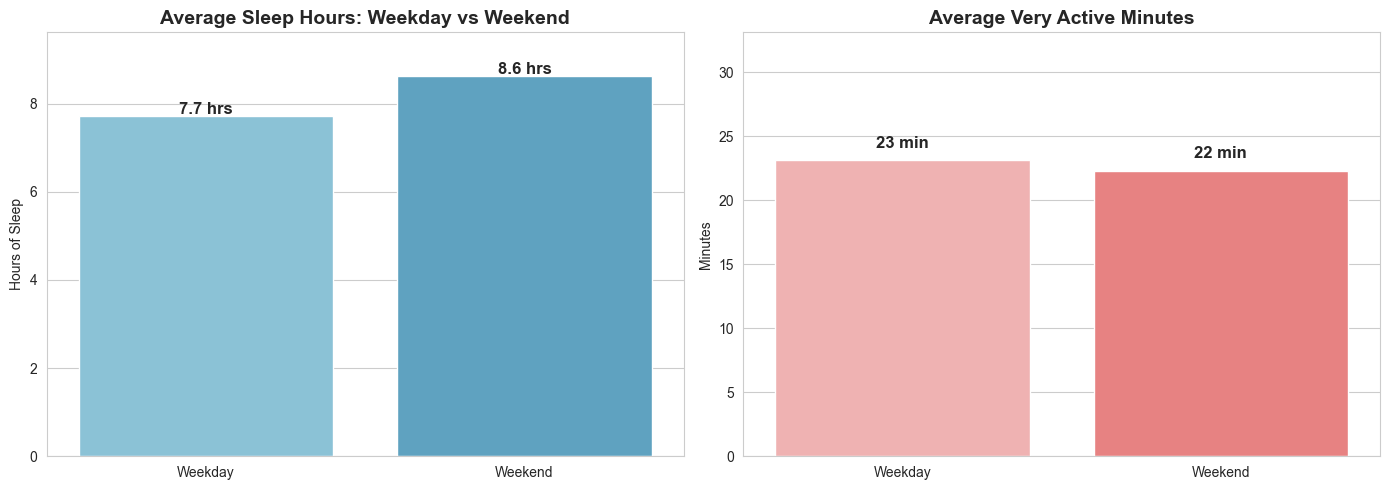

Saved: WWB_sleep_vs_activity.png


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare simple mean values for clearer visuals
summary = merged.groupby("IsWeekend")[["SleepHours", "VeryActiveMinutes"]].mean().reset_index()
summary["DayType"] = summary["IsWeekend"].map({True: "Weekend", False: "Weekday"})

# Set kid-friendly clean style
sns.set_style("whitegrid")

# === Figure setup ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ----------------------
# 📘 Visual 1: Sleep Hours
# ----------------------
sns.barplot(
    data=summary,
    x="DayType",
    y="SleepHours",
    hue="DayType",                # fix seaborn warning
    palette=["#7EC8E3", "#4FA8D0"],
    legend=False,
    ax=axes[0]
)

axes[0].set_title("Average Sleep Hours: Weekday vs Weekend", fontsize=14, weight="bold")
axes[0].set_ylabel("Hours of Sleep")
axes[0].set_xlabel("")

# Add value labels
for i, row in summary.iterrows():
    axes[0].text(i, row["SleepHours"] + 0.05, f"{row['SleepHours']:.1f} hrs",
                 ha='center', fontsize=12, weight='bold')

axes[0].set_ylim(0, summary["SleepHours"].max() + 1)


# ----------------------
# 📗 Visual 2: Very Active Minutes
# ----------------------
sns.barplot(
    data=summary,
    x="DayType",
    y="VeryActiveMinutes",
    hue="DayType",                # fix seaborn warning
    palette=["#F9A8A8", "#F87171"],
    legend=False,
    ax=axes[1]
)

axes[1].set_title("Average Very Active Minutes", fontsize=14, weight="bold")
axes[1].set_ylabel("Minutes")
axes[1].set_xlabel("")

# Add value labels
for i, row in summary.iterrows():
    axes[1].text(i, row["VeryActiveMinutes"] + 1, f"{row['VeryActiveMinutes']:.0f} min",
                 ha='center', fontsize=12, weight='bold')

axes[1].set_ylim(0, summary["VeryActiveMinutes"].max() + 10)

plt.tight_layout()
plt.show()

# === Save the images ===
fig.savefig("WWB_sleep_vs_activity.png", dpi=300, bbox_inches="tight")
print("Saved: WWB_sleep_vs_activity.png")


# ** Interpretation & Conclusion**

## **What the Data Shows**

After comparing weekdays and weekends, the results are very clear:

### **1. People sleep more on weekends**

* Weekday average: **about 7.7 hours**
* Weekend average: **about 8.6 hours**
* Weekend sleep is **almost 1 hour longer**

This difference is real and meaningful. The statistics show it is **not random**.

### **2. People are NOT more or less active on weekends**

* Weekday “very active minutes”: **about 23 minutes**
* Weekend “very active minutes”: **about 22 minutes**

This difference is tiny and **does not matter**. The statistical test shows it could easily be random.

## **What This Means (Simple Explanation)**

During the week, people probably have school, work, or other responsibilities, so they **wake up earlier** and **sleep slightly less**.

On weekends, people finally have time to **sleep in** and **catch up on rest**, which is why we see almost an extra hour of sleep.

But even though they sleep more, they **don’t change how much they move**. Their exercise or active time stays about the same whether it’s a weekday or a weekend.

## **Conclusion**

> **People in this study slept more on weekends, but they did not change how active they were.**
> Weekends mostly helped them **catch up on sleep**, not exercise more or less.

## **Why This Matters**

This pattern matches real life. Many people:

* Lose sleep during busy weekdays
* Catch up when they finally have free time
* Keep similar activity habits all week

Overall, the results support the original hypothesis for **sleep**, but **not for activity**.
